In [9]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics import Accuracy
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST

# Intermediate deep learning with PyTorch
## Chapter 1: Training robust neural networks

### Section1.1: object oriented programming

In [36]:
# Load the dataset
data = sns.load_dataset('iris')

# One-hot encode the 'species' column
data = pd.get_dummies(data, columns=['species'])

# Convert boolean columns to integers (0 and 1)
data = data.astype(int)

In [37]:
# Define the Dataset class
class MyDataset(Dataset):
    def __init__(self, data, feature_cols=None, label_cols=None):
        super().__init__()
        
        self.feature_cols = feature_cols if feature_cols is not None else data.columns[:-3]
        self.label_cols = label_cols if label_cols is not None else data.columns[-3:]

        # Ensure all data is numeric and drop rows with NaN values
        self.data = data.copy()
        self.data[self.feature_cols] = self.data[self.feature_cols].apply(pd.to_numeric, errors='coerce')
        self.data[self.label_cols] = self.data[self.label_cols].apply(pd.to_numeric, errors='coerce')
        self.data.dropna(inplace=True)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        features = torch.tensor(self.data.loc[idx, self.feature_cols].values, dtype=torch.float32)
        labels = torch.tensor(self.data.loc[idx, self.label_cols].values, dtype=torch.float32)
        return features, labels


In [44]:
# Define dataset and dataloader
# create an instance of the MyDataset class 
dataset = MyDataset(data, feature_cols=data.columns[:-3], label_cols=data.columns[-3:])
# create a data loader object
dataloader_train = DataLoader(dataset, batch_size=2, shuffle=True)
# batch_size=2 means that each batch will contain 2 samples

In [41]:
# Test the DataLoader
features, labels = next(iter(dataloader_train))
print('Features:', features)
print('Labels:', labels)

Features: tensor([[4., 2., 3., 1.],
        [4., 3., 1., 0.]])
Labels: tensor([[0., 1., 0.],
        [1., 0., 0.]])


In [42]:
# Test the DataLoader
features, labels = next(iter(dataloader_train))
print('Features:', features)
print('Labels:', labels)

Features: tensor([[5., 3., 4., 1.],
        [6., 3., 5., 2.]])
Labels: tensor([[0., 1., 0.],
        [0., 0., 1.]])


In [43]:
# Test the DataLoader
features, labels = next(iter(dataloader_train))
print('Features:', features)
print('Labels:', labels)

Features: tensor([[6., 3., 4., 1.],
        [7., 3., 6., 2.]])
Labels: tensor([[0., 0., 1.],
        [0., 0., 1.]])


#### sequential small models

In [47]:
net = nn.Sequential(
    nn.Linear(4, 10),
    nn.ReLU(),
    nn.Linear(10, 3),
    nn.ReLU(),
    nn.Linear(3, 3),
    nn.Sigmoid(),
)

#### Rewrite it using OOP

In [48]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 10)
        self.fc2 = nn.Linear(10, 3)
        self.fc3 = nn.Linear(3, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
    
net = Net()

- Before model training can commence, you need to load the data and pass it to the model in the right format. In PyTorch, this is handled by Datasets and DataLoaders. Let's start with building a PyTorch Dataset for our water potability data.

- In this exercise, you will define a class called WaterDataset to load the data from a CSV file. To do this, you will need to implement the three methods which PyTorch expects a Dataset to have:
    - .__init__() to load the data,
    - .__len__() to return data size,
    - .__getitem()__ to extract features and label for a single sample.

In [ ]:
class WaterDataset(Dataset):
    def __init__(self, csv_path):
        super().__init__()
        # Load data to pandas DataFrame
        df = pd.read_csv(csv_path)
        # Convert data to a NumPy array and assign to self.data
        self.data = df.to_numpy()
        
    # Implement __len__ to return the number of data samples
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        features = self.data[idx, :-1]
        # Assign last data column to label
        label = self.data[idx,-1]
        return features, label

- Create an instance of WaterDataset from water_train.csv, assigning it to dataset_train.
- Create dataloader_train based on dataset_train, using a batch size of two and shuffling the samples.
- Get a batch of features and labels from the DataLoader and print them.

In [ ]:
# Create an instance of the WaterDataset
dataset_train = WaterDataset("water_train.csv")

# Create a DataLoader based on dataset_train
dataloader_train = DataLoader(
    dataset_train,
    batch_size=2,
    shuffle=True,
)

# Get a batch of features and labels
features, labels = next(iter(dataloader_train))
print(features, labels)

- Let's build a model with three linear layers and ReLU activations. After the last linear layer, you need a sigmoid activation instead, which is well-suited for binary classification tasks like our water potability prediction problem. Here's the model defined using nn.Sequential(), which you may be more familiar with:

In [ ]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define the three linear layers
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        
    def forward(self, x):
        # Pass x through linear layers adding activations
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x

### Section1.2: optimiziers, training, and evaluation

#### optimizer

In [ ]:
net = Net()

# Define the Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.01)

train_model(
    optimizer=optimizer,
    net=net,
    num_epochs=10,
)

#### model evaluation

In [ ]:
# Set up binary accuracy metric
acc = Accuracy(task="binary")

net.eval()
with torch.no_grad():
    for features, labels in dataloader_test:
        # Get predicted probabilities for test data batch
        outputs = net(features)
        preds = (outputs >= 0.5).float()
        acc(preds, labels.view(-1, 1))

# Compute total test accuracy
test_accuracy = acc.compute()
print(f"Test accuracy: {test_accuracy}")

### Section1.3: vanishing and exploding gradients

#### initialization and activation

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        
        # Apply He initialization
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight, nonlinearity="sigmoid")

    def forward(self, x):
        # Update ReLU activation to ELU
        x = nn.functional.elu(self.fc1(x))
        x = nn.functional.elu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x

#### Batch normalization
- As a final improvement to the model architecture, let's add the batch normalization layer after each of the two linear layers. The batch norm trick tends to accelerate training convergence and protects the model from vanishing and exploding gradients issues.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        # Add two batch normalization layers
        self.bn1 = nn.BatchNorm1d(16)
        self.bn2 = nn.BatchNorm1d(8)
        
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight, nonlinearity="sigmoid")
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.elu(x)
		
        # Pass x through the second set of layers
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.elu(x)

        x = nn.functional.sigmoid(self.fc3(x))
        return x

## Chapter2: Images and CNN
### Section 2.1: handling images with PyTorch
#### image dataset

In [5]:
# Define transformations for the images (e.g., resizing, normalizing)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download CIFAR-10 to the local folder 'data'
#train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
#test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

# # Define transformations (optional for MNIST, since it's grayscale)
# transform = transforms.ToTensor()

# # Download MNIST
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


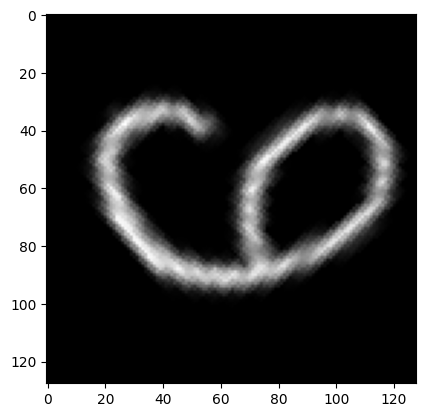

In [11]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),             # Resize images
    transforms.RandomRotation(45),             # Randomly rotate images
    transforms.ToTensor(),                     # Convert to tensor
])

# Load MNIST dataset with transformations
dataset_train = MNIST(
    root='data',
    train=True,
    transform=train_transforms,
    download=True
)

# Create DataLoader
dataloader_train = DataLoader(
    dataset_train, shuffle=True, batch_size=1
)

# Get a sample image and label from the DataLoader
image, label = next(iter(dataloader_train))

# Reshape the image tensor for display
# Remove .permute(1, 2, 0) since MNIST is single channel
image = image.squeeze()

plt.imshow(image, cmap='gray')
plt.show()

#### data agumentation
- First, you'll add the augmenting transformations to train_transforms. Let's use a random horizontal flip and a rotation by a random angle between 0 and 45 degrees. The code that follows to create the Dataset and the DataLoader is exactly the same as before. 
- Finally, you'll reshape the image and display it to see if the new augmenting transformations are visible.

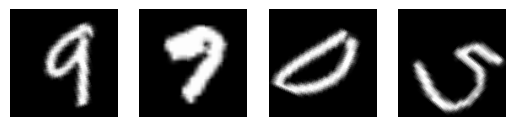

In [13]:
# Define transformations with data augmentation
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),             # Resize to a larger dimension (optional)
    transforms.RandomRotation(45),             # Randomly rotate images by 20 degrees
    transforms.RandomCrop(128, padding=4),     # Randomly crop image with padding
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Randomly translate
    transforms.ToTensor(),                     # Convert image to a tensor
    transforms.Normalize((0.5,), (0.5,))       # Normalize for grayscale image
])

# Load MNIST training dataset with transformations
dataset_train = MNIST(
    root='data',
    train=True,
    transform=train_transforms,
    download=True
)

# Create DataLoader
dataloader_train = DataLoader(
    dataset_train, shuffle=True, batch_size=1
)

# Display a few augmented images
for i in range(4):
    image, label = next(iter(dataloader_train))
    image = image.squeeze()   # Remove the channel dimension for grayscale
    image = image * 0.5 + 0.5 # Unnormalize to [0, 1] for display
    plt.subplot(1, 4, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.show()


### Section 2.2: CNN
#### Building convolutional networks
- You are on a team building a weather forecasting system. As part of the system, cameras will be installed at various locations to take pictures of the sky. Your task is to build a model to classify different cloud types in these pictures, which will help spot approaching weather fronts.
- You decide to build a convolutional image classifier. The model will consist of two parts:

        - A feature extractor that learns a vector of features from the input image,
        - A classifier that predicts the image's class based on the learned features.

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        # Define classifier
        self.classifier = nn.Linear(64*16*16, num_classes)
    
    def forward(self, x):  
        # Pass input through feature extractor and classifier
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

#### dataset with augmentation
- You have already built the image dataset from cloud pictures and the convolutional model to classify different cloud types. Before you train it, let's adapt the dataset by adding the augmentations that could improve the model's cloud classification performance.

- The code to set up the Dataset and DataLoader is already prepared for you and should look familiar. Your task is to define the composition of transforms that will be applied to the input images as they are loaded.

- Note that before you were resizing images to 128 by 128 to display them nicely, but now you will use smaller ones to speed up training. As you will see later, 64 by 64 will be large enough for the model to learn.

In [ ]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])

dataset_train = ImageFolder(
  "clouds_train",
  transform=train_transforms,
)
dataloader_train = DataLoader(
  dataset_train, shuffle=True, batch_size=16
)

#### Image classifier training loop
- Define the model using your Net class with num_classes set to 7 and assign it to net.
- Define the loss function as cross-entropy loss and assign it to criterion.
- Define the optimizer as Adam, passing it the model's parameters and the learning rate of 0.001, and assign it to optimizer.
- Start the training for-loop by iterating over training images and labels.

In [ ]:
# Define the model
net = Net(num_classes=7)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(3):
    running_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

#### multi-class model evaluation
- Let's evaluate our cloud classifier with precision and recall to see how well it can classify the seven cloud types. In this multi-class classification task it is important how you average the scores over classes. Recall that there four approaches:

- Not averaging, and analyzing the results per class;
- Micro-averaging, ignoring the classes and computing the metrics globally;
- Macro-averaging, computing metrics per class and averaging them;
- Weighted-averaging, just like macro but with the average weighted by class size.

In [16]:
from torchmetrics import Precision, Recall

In [ ]:
# Define metrics
metric_precision = Precision(task='multiclass', num_classes=7, 
average="micro")
metric_recall = Recall(task='multiclass', num_classes=7, 
average="micro")

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

- While aggregated metrics are useful indicators of the model's performance, it is often informative to look at the metrics per class. This could reveal classes for which the model underperforms.

- In this exercise, you will run the evaluation loop again to get our cloud classifier's precision, but this time per-class. Then, you will map these score to the class names to interpret them. As usual, Precision has already been imported for you. Good luck!

In [ ]:
# Define precision metric
metric_precision = Precision(task='multiclass', num_classes=7, 
average=None)

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
precision = metric_precision.compute()

# Get precision per class
precision_per_class = {
    k: precision[v].item()
    for k, v 
    in dataset_test.class_to_idx.items()
}
print(precision_per_class)